In [26]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import BINNCovasim
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, AIC_OLS, RSS

In [27]:
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

In [28]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# choose and get data
path = '../Data/covasim_data/xin_data/'
population = 200000
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
chi_type = 'piecewise'
case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

Device set to cpu


In [29]:
data = params['data']
data = (data / params['population']).to_numpy()
N = len(data)
t_max = N - 1
t = np.arange(N)
params.pop('data')

,S,T,E,A,Y,D,Q,R,F
0,199600,0,400,0,0,0,0,0,0
1,199599,0,400,0,1,0,0,0,0
2,199593,0,389,5,13,0,0,0,0
3,199559,0,313,38,88,2,0,0,0
4,199480,0,290,69,150,11,0,0,0
...,...,...,...,...,...,...,...,...,...
178,110328,1152,956,661,871,640,14,84920,458
179,110278,1056,917,640,868,636,13,85134,458
180,110210,970,899,660,838,642,11,85309,461
181,110103,922,909,652,814,633,14,85491,462


In [30]:
tracing_array = params['tracing_array']

mydir = '../models/covasim/2023-06-21_00-12-29' # piecewise h(t) function

In [31]:
# instantiate BINN model
binn = BINNCovasim(params, t_max, tracing_array, keep_d=keep_d).to(device)

In [32]:
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [33]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data[0, :].copy()

In [34]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

# do regression to figure out contact rate
def contact_rate_regression(u):
    s, a, y = u[:, 0][:, None], u[:, 1][:, None], u[:, 2][:, None]
    features = [np.ones_like(a), s, s**2, a, y] #
    features = np.concatenate(features, axis=1)
    res = features @ regression_coefs_cr
    # res *= 1.4
    return res

# do regression to figure out tracing rate
def beta_regression(u):
    a, b = u[:, 0][:, None], u[:, 1][:, None]
    features = [np.ones_like(a), a, b] #
    features = np.concatenate(features, axis=1)
    res = features @ regression_coefs_qt
    return res

# do regression to figure out diagnoses rate (on quarantined folks)
def tau_regression(u):
    a, b = u[:, 0][:, None], u[:, 1][:, None]
    features = [np.ones_like(a), a, b] #
    features = np.concatenate(features, axis=1)
    res = features @ regression_coefs_tau
    return res


In [35]:
# simulate PDE. First grab the parameter values from the loaded BINN model.
params['yita_lb'] = model.model.yita_lb
params['yita_ub'] = model.model.yita_ub
params['beta_lb'] = model.model.beta_lb
params['beta_ub'] = model.model.beta_ub
params['tau_lb'] = model.model.tau_lb
params['tau_ub'] = model.model.tau_ub

In [36]:
# if D is to be included in the model, otherwise use the other solver.
if keep_d:
    RHS = PDESolver.STEAYDQRF_RHS_dynamic
    u_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate, beta, tau, params, chi_type)
    u_sim_NN *= population
    
    # commented out evaluations with regression models
    #u_sim_regression = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate_regression, beta_regression, tau_regression, params, chi_type)
    #u_sim_regression *= population

c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([ds, dt, de, da, dy, dd, dq, dr, df])


In [37]:
# rescale data values to represent number of people in state X rather than ratios
data *= population

plot=True
if plot:
    # data = params['data']
    n = data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # t = np.arange(1, data.shape[0] + 1)
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, data[:, i - 1], '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '.png') )
        # plt.show()

In [ ]:
# %% optional, add one comparison based on the results ODE-DE
de_res_file = 'fitted_' + case_name + '.csv'
ode_de_df = pd.read_csv('../Data/covasim_data/xin_data/' + de_res_file, index_col=0)
ode_de_array = ode_de_df.to_numpy()
# plot compartments
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(18, 9))
for i in range(1, n):
    ax = fig.add_subplot(2, 4, i) # int(np.ceil(n / 4))
    ax.plot(t, data[:, i - 1], '.k', label='Test-ABM')
    ax.plot(t, u_sim_NN[:, i - 1], 'r.-', label='ODE-NN')
    ax.plot(t, ode_de_array[:, i - 1], 'g.-', label='ODE-DE')
    if i > 5:
        ax.set_xlabel("Time (Days)")
    if i % 3 == 1:
        ax.set_ylabel("Count")
    ax.set_title(col_names[i - 1])
    if i == 1:
        ax.legend(loc="best")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.tight_layout(pad=2)
    plt.savefig(os.path.join(model.save_folder, case_name + '_without_F' + '.png'), dpi=300)
    # plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/covasim_data/fitted_200000_0.1_0.3_dynamic_piecewise.csv'

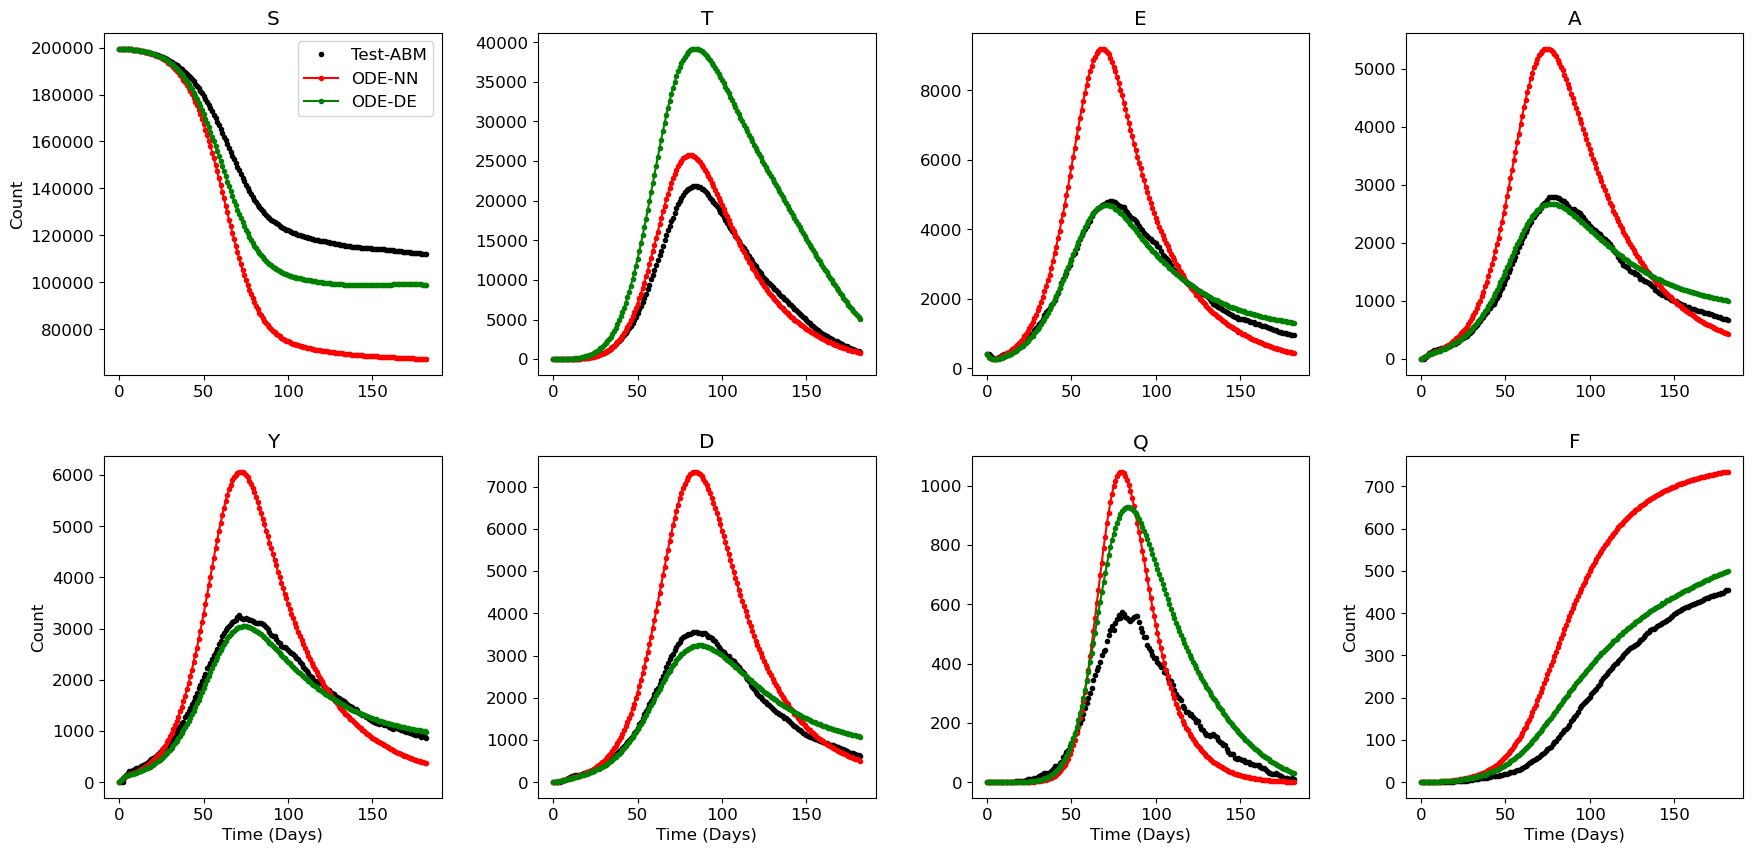

In [ ]:
# %% save without R
fig = plt.figure(figsize=(18, 9))
for i in range(1, n + 1):
    if i == n - 1:
        continue
    ax = fig.add_subplot(2, 4, i) if i < n else fig.add_subplot(2, 4, i - 1) # int(np.ceil(n / 4))
    ax.plot(t, data[:, i - 1], '.k', label='Test-ABM')
    ax.plot(t, u_sim_NN[:, i - 1], 'r.-', label='ODE-NN')
    ax.plot(t, ode_de_array[:, i - 1], 'g.-', label='ODE-DE')
    if i > 4:
        ax.set_xlabel("Time (Days)")
    if i % 4 == 1:
        ax.set_ylabel("Count")
    ax.set_title(col_names[i - 1])
    if i == 1:
        ax.legend(loc="best")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.tight_layout(pad=2)
    plt.savefig(os.path.join(model.save_folder, case_name + '_without_R' + '.png'), dpi=300)

In [ ]:
#%% RMSE
from sklearn.metrics import mean_squared_error
rmse_NN = {}
rmse_SR = {}
rmse_DE = {}
for i, col in enumerate(col_names):
    res = mean_squared_error(data[:, i], u_sim_NN[:,i], squared=False)
    rmse_NN[col] = res
    rmse_SR[col] = res
    res = mean_squared_error(data[:, i], ode_de_array[:, i], squared=False)
    rmse_DE[col] = res
rmse_df = pd.DataFrame([rmse_NN, rmse_SR, rmse_DE], index=['ODE-NN', 'ODE-SR', 'ODE-DE'])
rmse_df['Mean'] = rmse_df.mean(axis=1)
rmse_df.to_csv(os.path.join(model.save_folder, case_name + '_rmse' + '.csv'))

In [ ]:
#%% NRMSE
from sklearn.metrics import mean_squared_error
nrmse_NN = {}
nrmse_SR = {}
nrmse_DE = {}
for i, col in enumerate(col_names):
    y_max, y_min = max(data[:, i]), min(data[:, i])
    res = mean_squared_error(data[:, i], u_sim_NN[:,i], squared=False) / (y_max - y_min)
    nrmse_NN[col] = res
    nrmse_SR[col] = res
    res = mean_squared_error(data[:, i], ode_de_array[:, i], squared=False) / (y_max - y_min)
    nrmse_DE[col] = res
nrmse_df = pd.DataFrame([nrmse_NN, nrmse_SR, nrmse_DE], index=['ODE-NN', 'ODE-SR', 'ODE-DE'])
nrmse_df['Mean'] = nrmse_df.mean(axis=1)
nrmse_df.to_csv(os.path.join(model.save_folder, case_name + '_nrmse' + '.csv'))